Si reviso `rmbsinbcn` noto que hay puntos que en realidad están dentro del municipio de Barcelona. Por tanto, lo que haré será:
1. Unir `rmbsinbcn` con `bcn`.
2. Eliminar duplicados de la base resultante.
3. Considerar como `bcn` sólo a los puntos que están dentro del municipio (basándome en el [shapefile](https://centrodedescargas.cnig.es/CentroDescargas/catalogo.do?Serie=CAANE)), lo que me dará el archivo `bcn_marzo2024-f2.xlsx`.
4. Obtener una base que sea `rmb_marzo2024-f1.xlsx`.

Así, finalmente tendré tres bases de datos: `madrid_marzo2024-f1.xlsx` (para toda la CC.AA.), `bcn_marzo2024-f2.xlsx` (sólo el municipio) y `rmb_marzo2024-f1.xlsx`.

# Revisión inicial

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

In [2]:
# Leer el DataFrame con las coordenadas
rmbsinbcn = pd.read_excel('data/filtrado/rmbsinbcn_marzo2024-f1.xlsx') 
bcn=pd.read_excel('data/filtrado/bcn_marzo2024-f1.xlsx') 

#### RMB SIN BCN
# Convertir el DataFrame a un GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(rmbsinbcn['Lon_X'], rmbsinbcn['Lat_Y'])]
crs = {'init': 'epsg:4326'}  # Definir sistema de coordenadas WGS84
gdf_puntos = gpd.GeoDataFrame(rmbsinbcn, crs=crs, geometry=geometry)

# Convertir el GeoDataFrame a EPSG:32631
gdf_puntos = gdf_puntos.to_crs(epsg=32631)

#### BCN
# Convertir el DataFrame a un GeoDataFrame
geometry2 = [Point(lon, lat) for lon, lat in zip(bcn['Lon_X'], bcn['Lat_Y'])]
gdf_puntos2 = gpd.GeoDataFrame(bcn, crs=crs, geometry=geometry2)

# Convertir el GeoDataFrame a EPSG:32631
gdf_puntos2 = gdf_puntos2.to_crs(epsg=32631)

# Leer el archivo geopackage de municipios
gdf_municipios = gpd.read_file('G:/Mi unidad/Datos/bcn/vectores/MUNICIPOS-ESPAÑA-31N.gpkg')

C:\Users\rojas\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\rojas\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


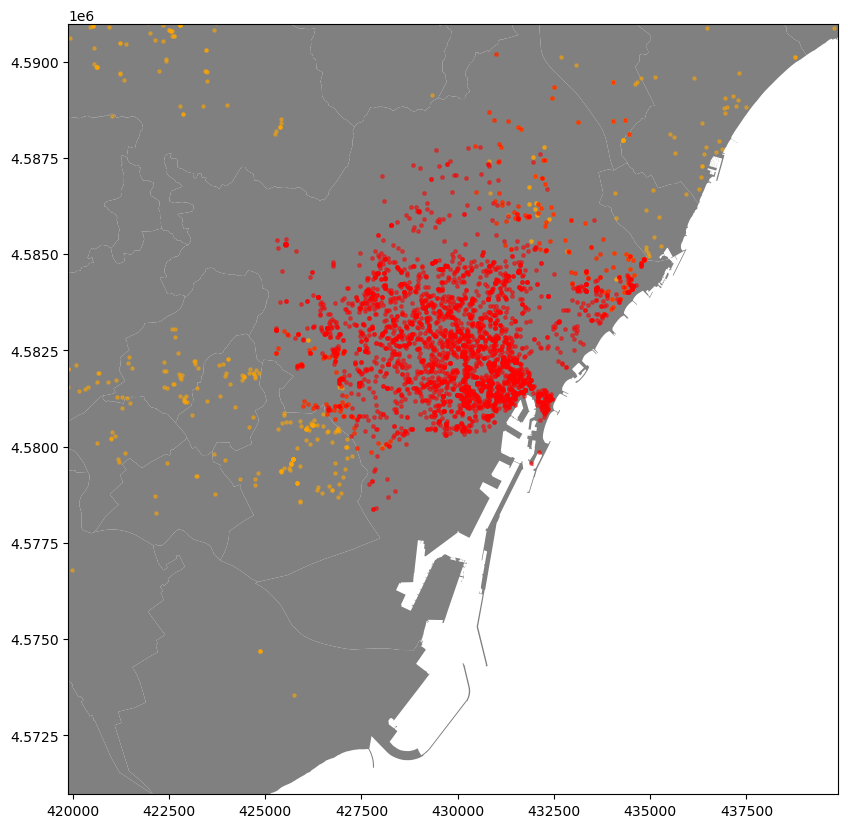

In [3]:
# Calcular el centro de los puntos
center_point = gdf_puntos2.geometry.unary_union.centroid

# Visualizar los datos centrados en los puntos
fig, ax = plt.subplots(figsize=(10, 10))
gdf_municipios.plot(ax=ax, color='gray')
gdf_puntos.plot(ax=ax, color='orange', markersize=5, alpha=0.5)
gdf_puntos2.plot(ax=ax, color='red', markersize=6, alpha=0.5)
ax.set_xlim([center_point.x - 10000, center_point.x + 10000])  # Ajustar límites x para centrar en puntos
ax.set_ylim([center_point.y - 10000, center_point.y + 10000])  # Ajustar límites y para centrar en puntos
plt.show()

# 1. Unión de `bcn` con `rmbsinbcn`

In [4]:
rmbsinbcn = pd.read_excel('data/filtrado/rmbsinbcn_marzo2024-f1.xlsx') 
bcn=pd.read_excel('data/filtrado/bcn_marzo2024-f1.xlsx') 

In [5]:
# Concatenar los DataFrames uno debajo del otro
df = pd.concat([rmbsinbcn, bcn], axis=0)
len(df)

5010

# 2. Reviso duplicados

In [6]:
columns_to_keep = ['codigo_inmueble', 'Lon_X', 'Lat_Y']

# Crear una lista de columnas excluyendo las columnas que deseas mantener
columns_to_check_duplication = [col for col in df.columns if col not in columns_to_keep]

# Si quieres modificar directamente el DataFrame original, puedes hacer:
df.drop_duplicates(subset=columns_to_check_duplication, keep='first', inplace=True)

# Verificar el DataFrame resultante
len(df)

5010

Convierto el df a una versión georreferenciada.

In [7]:
# Convertir el DataFrame a un GeoDataFrame
geometry3 = [Point(lon, lat) for lon, lat in zip(df['Lon_X'], df['Lat_Y'])]
crs = {'init': 'epsg:4326'}  # Definir sistema de coordenadas WGS84
gdf_puntos3 = gpd.GeoDataFrame(df, crs=crs, geometry=geometry3)

# Convertir el GeoDataFrame a EPSG:25831
gdf_puntos3 = gdf_puntos3.to_crs(epsg=32631)

C:\Users\rojas\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# 3. Nueva versión de `bcn`

In [8]:
gdf_municipios.head(1)

,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,ES.IGN.BDDAE.34010404001,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34010404001,Abla,ES6,ES61,ES611,"MULTIPOLYGON (((-14292.138 4120932.645, -14246..."


In [9]:
gdf_filtrado = gdf_municipios[gdf_municipios['NAMEUNIT'] == 'Barcelona']

In [20]:
# Realizar una unión espacial entre los dos GeoDataFrames
nuevo_bcn = gpd.sjoin(gdf_puntos3, gdf_filtrado[['geometry']], how='inner', op='intersects')

C:\Users\rojas\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
nuevo_bcn.head()

,Title,Link,precio_euros,codigo_inmueble,Description,last_mod,dummy_indice,indice_alquiler,area,n_rooms,...,parking,pool,lift,furniture,public_transp,barrio,Lat_Y,Lon_X,geometry,index_right
99,Alquiler Piso Carrer de sabino arana. Oportun...,https://www.habitaclia.com/alquiler-piso-oport...,1900,26177004398072,OPORTUNIDAD PISO EN ZONA PRIVILEGIADAEdificio ...,07/03/2024,0,0.0,125,4,...,0,0,0,0,1,Sant Ramon,41.385743,2.124916,POINT (426834.500 4581949.040),5116
100,Alquiler Piso en Sant Ramon - Maternitat. Pi...,https://www.habitaclia.com/alquiler-piso-en_le...,1590,5883004303283,"Piso semiamueblado en Les Corts, a un paso de...",21/03/2024,0,0.0,98,4,...,1,0,0,1,1,Sant Ramon,41.377647,2.114932,POINT (425990.536 4581058.733),5116
101,Alquiler Piso Avinguda de madrid. Piso de 4 h...,https://www.habitaclia.com/alquiler-piso-de_4_...,1800,37701000000071,Apartamento en alquiler por un máximo de 11 me...,06/03/2024,0,0.0,90,4,...,0,0,0,1,0,Sant Ramon,41.377739,2.125850,POINT (426903.562 4581059.638),5116
102,Alquiler Piso Carrer de mejía lequerica. Piso...,https://www.habitaclia.com/alquiler-piso-de_10...,2200,21241000012240,REF. 001625RPRECIO DE ALQUILER DE CORTA ESTANC...,07/02/2024,0,0.0,107,4,...,0,0,0,0,0,Sant Ramon,41.383868,2.125944,POINT (426918.324 4581739.999),5116
103,Alquiler Piso en Avinguda de madrid 27. ¡ref...,https://www.habitaclia.com/alquiler-piso-refor...,1150,12792003591115,Av. Madrid - Regent de Mendieta - ArizalaPreci...,19/03/2024,0,0.0,50,2,...,0,0,0,0,0,Sant Ramon,41.376831,2.124354,POINT (426777.485 4580960.146),5116


In [22]:
len(nuevo_bcn)

3744

In [23]:
nuevo_bcn.drop(['geometry','index_right'],axis=1).to_excel('data/filtrado/bcn_marzo2024-f2.xlsx',index=False)

# 4. Obtengo la base de datos para el RMB

In [17]:
df.to_excel('data/filtrado/rmb_marzo2024-f1.xlsx',index=False)